#Intro

Tugas besar aml. Dataset yang diguakan adalah weatherAUS. Akan dilakukan pengujian untuk membandingkan kualitas model dan waktu yang dibutuhkan untuk training model dari data yang diproses pca dengan yang tidak. AutoML menggunakan TPOT Light

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import timeit

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
!pip install tpot
from tpot import TPOTClassifier

     |████████████████████████████████| 87 kB 4.2 MB/s 
     |████████████████████████████████| 160 kB 37.4 MB/s 
     |████████████████████████████████| 173.5 MB 13 kB/s 
  Created wheel for stopit: filename=stopit-1.1.2-py3-none-any.whl size=11952 sha256=98d7aade2dfceef9b13a136fe9e6c6d2f8b9cc8077e5b3a9df71373ec428d8cb
  Stored in directory: /root/.cache/pip/wheels/e2/d2/79/eaf81edb391e27c87f51b8ef901ecc85a5363dc96b8b8d71e3
Successfully built stopit
  Attempting uninstall: xgboost
    Found existing installation: xgboost 0.90
    Uninstalling xgboost-0.90:
      Successfully uninstalled xgboost-0.90


#Explorasi Data

In [ ]:
df = pd.read_csv('weatherAUS.csv')

print(f"Jumlah record: {df.shape[0]}")
print(f"Jumlah feature: {df.shape[1]}")

Jumlah record: 145460
Jumlah feature: 23


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

In [ ]:
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [ ]:
# Dataframe statistics
df.describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
count,143975.000000,144199.000000,142199.000000,82670.000000,75625.000000,135197.000000,143693.000000,142398.000000,142806.000000,140953.000000,130395.00000,130432.000000,89572.000000,86102.000000,143693.000000,141851.00000
mean,12.194034,23.221348,2.360918,5.468232,7.611178,40.035230,14.043426,18.662657,68.880831,51.539116,1017.64994,1015.255889,4.447461,4.509930,16.990631,21.68339
std,6.398495,7.119049,8.478060,4.193704,3.785483,13.607062,8.915375,8.809800,19.029164,20.795902,7.10653,7.037414,2.887159,2.720357,6.488753,6.93665
min,-8.500000,-4.800000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,980.50000,977.100000,0.000000,0.000000,-7.200000,-5.40000
25%,7.600000,17.900000,0.000000,2.600000,4.800000,31.000000,7.000000,13.000000,57.000000,37.000000,1012.90000,1010.400000,1.000000,2.000000,12.300000,16.60000
50%,12.000000,22.600000,0.000000,4.800000,8.400000,39.000000,13.000000,19.000000,70.000000,52.000000,1017.60000,1015.200000,5.000000,5.000000,16.700000,21.10000
75%,16.900000,28.200000,0.800000,7.400000,10.600000,48.000000,19.000000,24.000000,83.000000,66.000000,1022.40000,1020.000000,7.000000,7.000000,21.600000,26.40000
max,33.900000,48.100000,371.000000,145.000000,14.500000,135.000000,130.000000,87.000000,100.000000,100.000000,1041.00000,1039.600000,9.000000,9.000000,40.200000,46.70000


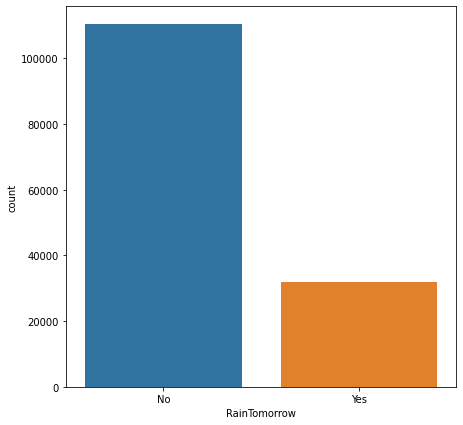

In [ ]:
# Countplot showing data imbalance
plt.figure(figsize=(7,7))
sns.countplot(x='RainTomorrow',data=df)
plt.show()

#Preprocessing Data

##Unuseful Feature

In [ ]:
# Dropping date feature
df = df.drop('Date', axis=1)

##Missing Values

In [ ]:
df.isna().sum()

Location             0
MinTemp           1485
MaxTemp           1261
Rainfall          3261
Evaporation      62790
Sunshine         69835
WindGustDir      10326
WindGustSpeed    10263
WindDir9am       10566
WindDir3pm        4228
WindSpeed9am      1767
WindSpeed3pm      3062
Humidity9am       2654
Humidity3pm       4507
Pressure9am      15065
Pressure3pm      15028
Cloud9am         55888
Cloud3pm         59358
Temp9am           1767
Temp3pm           3609
RainToday         3261
RainTomorrow      3267
dtype: int64

In [ ]:
# Missing value percentage
missing_percentage = (df.isna().sum()/len(df)) * 100
missing_percentage

Location          0.000000
MinTemp           1.020899
MaxTemp           0.866905
Rainfall          2.241853
Evaporation      43.166506
Sunshine         48.009762
WindGustDir       7.098859
WindGustSpeed     7.055548
WindDir9am        7.263853
WindDir3pm        2.906641
WindSpeed9am      1.214767
WindSpeed3pm      2.105046
Humidity9am       1.824557
Humidity3pm       3.098446
Pressure9am      10.356799
Pressure3pm      10.331363
Cloud9am         38.421559
Cloud3pm         40.807095
Temp9am           1.214767
Temp3pm           2.481094
RainToday         2.241853
RainTomorrow      2.245978
dtype: float64

In [ ]:
# Removing features with big missing percentage
df = df.drop(['Evaporation','Sunshine','Cloud9am','Cloud3pm'], axis=1)
df.shape

(145460, 18)

In [ ]:
# Removing records with no label
df['RainTomorrow'] = df['RainTomorrow'].dropna(axis=0)
df.shape

(145460, 18)

In [ ]:
# Replace missing values with mode and mean
cat_col = [i for i in df.select_dtypes(include='object')]
num_col = [i for i in df.select_dtypes(include='number')]

for col in cat_col:
    df[col] =  df[col].fillna(df[col].mode()[0])

for col in num_col:
    df[col] = df[col].fillna(df[col].mean())

In [ ]:
df.isna().sum()

Location         0
MinTemp          0
MaxTemp          0
Rainfall         0
WindGustDir      0
WindGustSpeed    0
WindDir9am       0
WindDir3pm       0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Temp9am          0
Temp3pm          0
RainToday        0
RainTomorrow     0
dtype: int64

In [ ]:
df.head()

,Location,MinTemp,MaxTemp,Rainfall,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,Albury,13.4,22.9,0.6,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,16.9,21.8,No,No
1,Albury,7.4,25.1,0.0,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,17.2,24.3,No,No
2,Albury,12.9,25.7,0.0,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,21.0,23.2,No,No
3,Albury,9.2,28.0,0.0,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,18.1,26.5,No,No
4,Albury,17.5,32.3,1.0,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,17.8,29.7,No,No


##Data Transformation

In [ ]:
# Label Encoding
le = LabelEncoder()

for col in cat_col:
    df[col] = le.fit_transform(df[col])

In [ ]:
df.head()

,Location,MinTemp,MaxTemp,Rainfall,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2,13.4,22.9,0.6,13,44.0,13,14,20.0,24.0,71.0,22.0,1007.7,1007.1,16.9,21.8,0,0
1,2,7.4,25.1,0.0,14,44.0,6,15,4.0,22.0,44.0,25.0,1010.6,1007.8,17.2,24.3,0,0
2,2,12.9,25.7,0.0,15,46.0,13,15,19.0,26.0,38.0,30.0,1007.6,1008.7,21.0,23.2,0,0
3,2,9.2,28.0,0.0,4,24.0,9,0,11.0,9.0,45.0,16.0,1017.6,1012.8,18.1,26.5,0,0
4,2,17.5,32.3,1.0,13,41.0,1,7,7.0,20.0,82.0,33.0,1010.8,1006.0,17.8,29.7,0,0


##Outliers

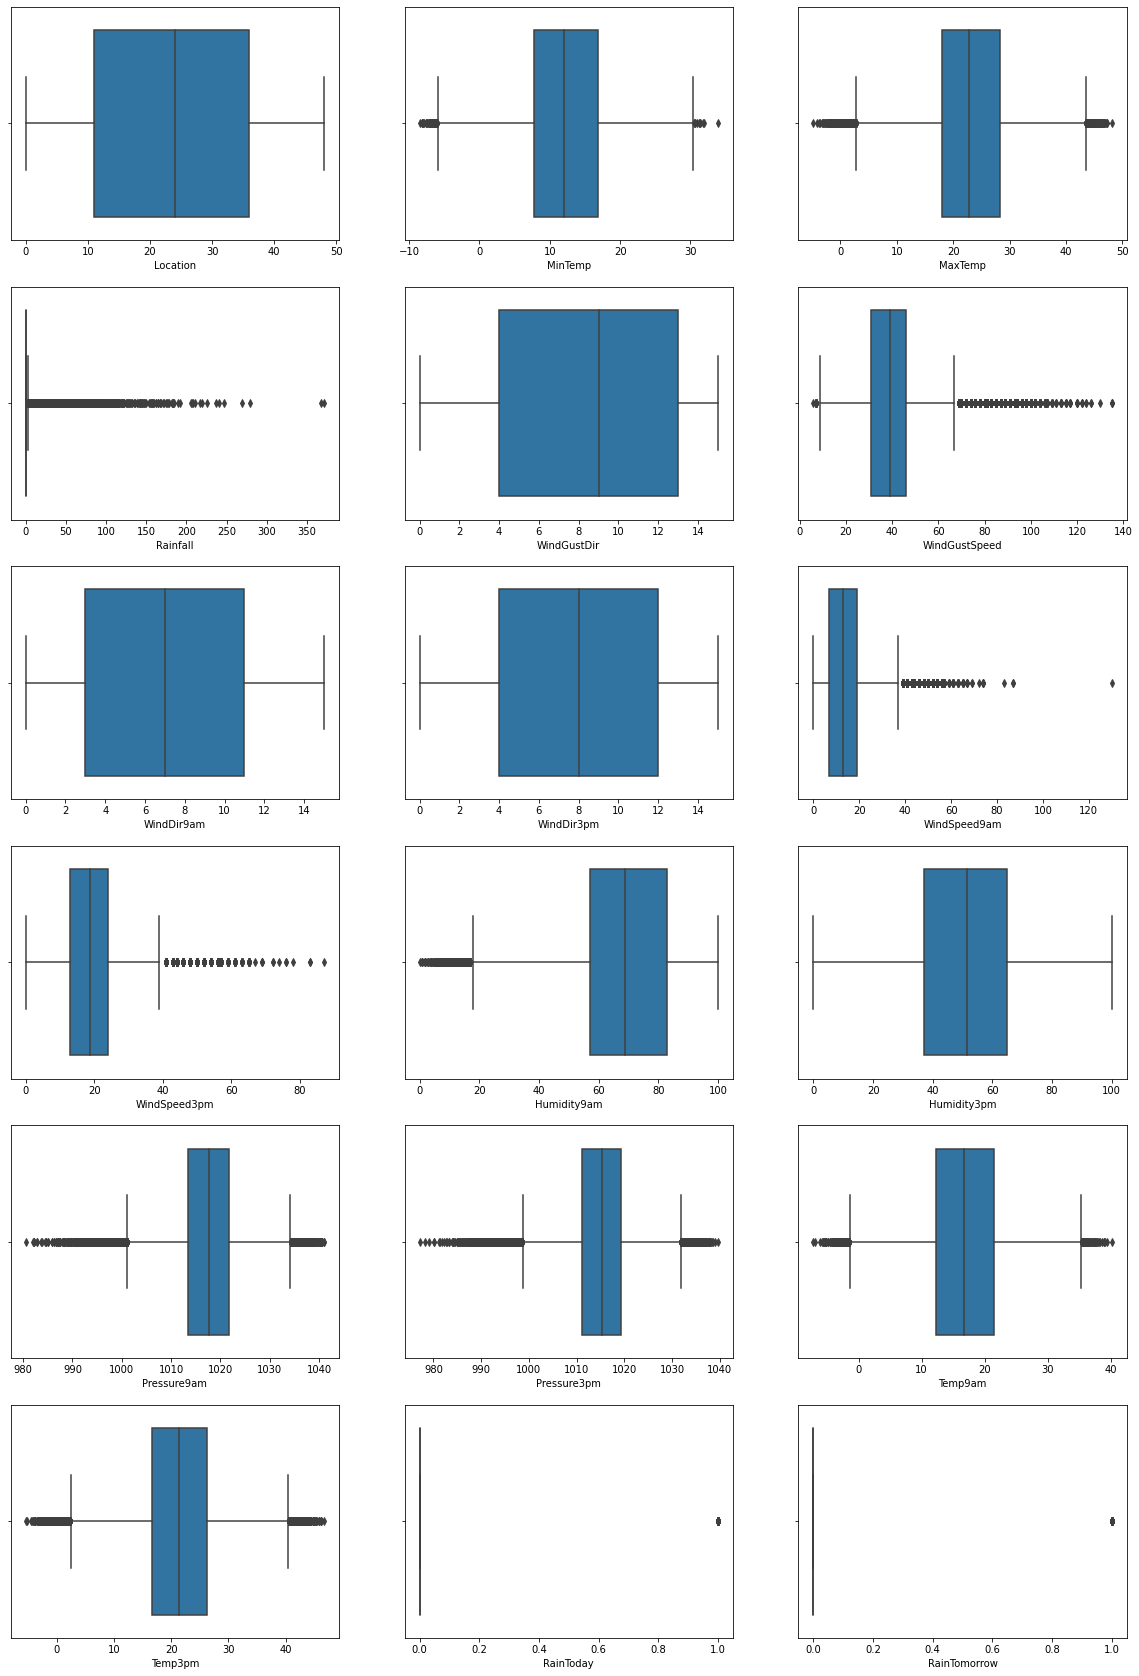

In [ ]:
# Boxplot
fig, axes = plt.subplots(ncols=3, nrows=6, figsize=(20,30))
for i, ax in zip(df.columns, axes.flat):
    sns.boxplot(x=df[i], ax=ax)
plt.show()

In [ ]:
# Removing outlier using Z score
df_clean = df[(np.abs(stats.zscore(df)) < 3).all(axis=1)]
print(f'Deleted records: {df.shape[0]-df_clean.shape[0]}')

Deleted records: 7252


##Duplicate Data

In [ ]:
# Removing duplicate records
print(f'Number of duplicate: {df_clean.duplicated().sum()}')
df_clean.drop_duplicates(keep='first', inplace=True)
print(f'Number of duplicate after removal: {df_clean.duplicated().sum()}')

Number of duplicate: 282
Number of duplicate after removal: 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
df_clean.shape

(137926, 18)

##Multicollinearity

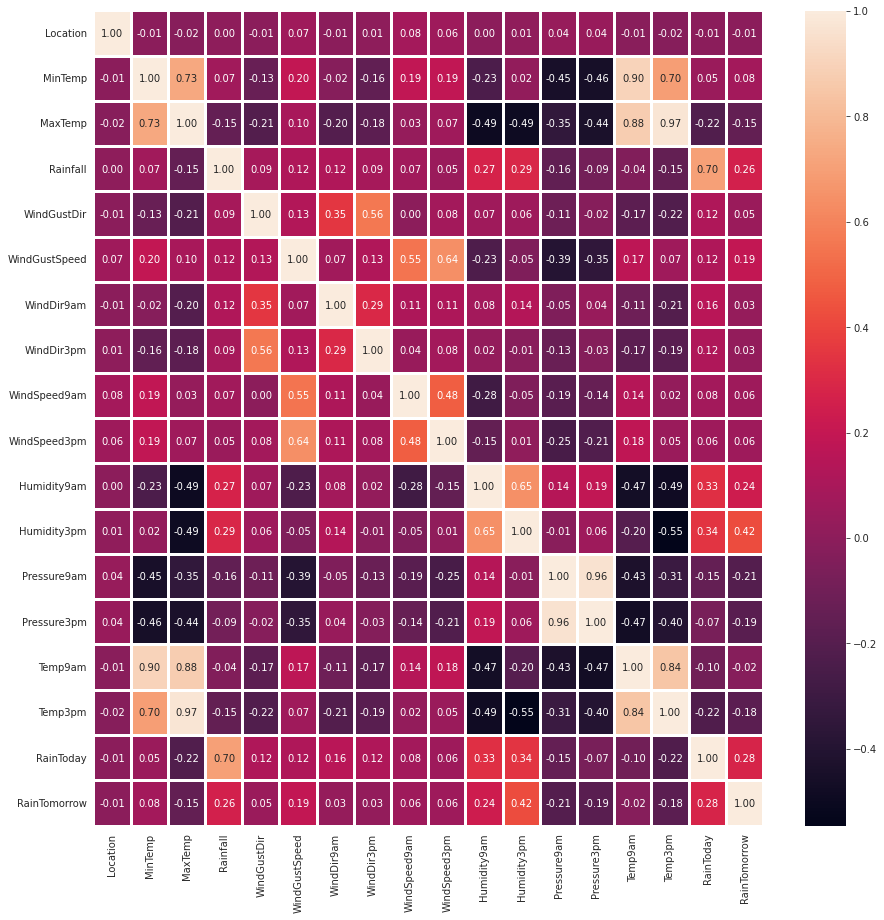

In [ ]:
# Heatmap
sns.set({'figure.figsize':(15,15)})
sns.heatmap(df_clean.corr(), annot=True, fmt='.2f', linewidths= 2)

Dapat dilihat bahwa terdapat multicollinearity dari heatmap yang dihasilkan. Contohnya, Temp9am dengan MinTemp dan MaxTemp, RainToday dengan Rainfall.

#Model

##Scaling

In [ ]:
X = df_clean.drop('RainTomorrow', axis=1)
y = df_clean['RainTomorrow']

# Scaling with starndard scaler
scaler = StandardScaler()
X_Scaled = scaler.fit_transform(X)

##PCA

Eigenvalues:
[4.79781063 2.89431801 1.93286314 1.51887594 1.11707513 0.98295246
 0.95030178 0.6906339  0.53396647 0.43433309 0.35016989 0.30754061
 0.2928075  0.106719   0.03773539 0.02739204 0.02462826]

Variances (Percentage):
[28.22221087 17.02527662 11.36970077  8.9344996   6.57098252  5.78203136
  5.58996997  4.06252292  3.14095643  2.55488201  2.05980796  1.80904931
  1.72238457  0.6277543   0.22197129  0.16112845  0.14487106]



Text(0, 0.5, 'Explained variance (%)')

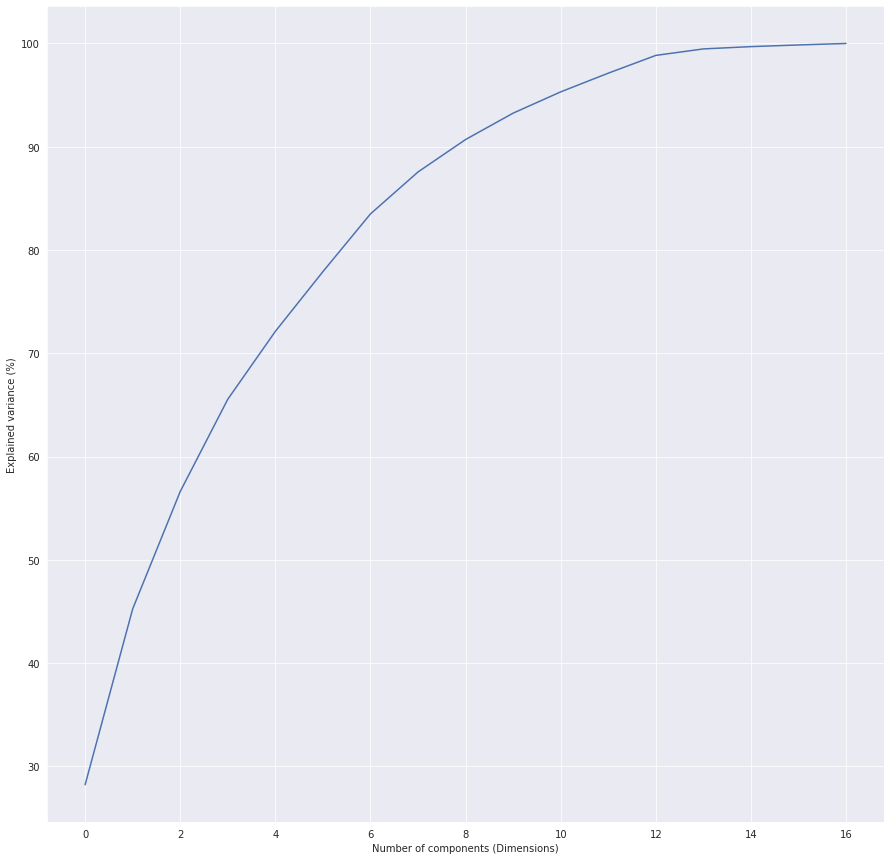

In [ ]:
# Apply PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=None)
pca.fit(X_Scaled)

# Get the eigenvalues
print("Eigenvalues:")
print(pca.explained_variance_)
print()

# Get explained variances
print("Variances (Percentage):")
print(pca.explained_variance_ratio_ * 100)
print()

# Make the scree plot
plt.plot(np.cumsum(pca.explained_variance_ratio_ * 100))
plt.xlabel("Number of components (Dimensions)")
plt.ylabel("Explained variance (%)")

8 components sudah memberikan di atas 90% variance

In [ ]:
# Do feature scaling
sc = StandardScaler()
X_scaled = sc.fit_transform(X)

# Apply PCA for 8 components
from sklearn.decomposition import PCA
pca = PCA(n_components=8)
X_pca = pca.fit_transform(X_scaled)

# Get the transformed dataset
X_pca = pd.DataFrame(X_pca)
print(X_pca.head())
print("\nSize: ")
print(X_pca.shape)

          0         1         2  ...         5         6         7
0  1.124017  1.753987 -1.544128  ...  1.055482 -0.683731  0.604770
1  1.153195  0.349833 -1.563967  ...  1.465434  0.549071 -0.532029
2  1.961211  1.696918 -2.249024  ...  1.150411 -0.756514  0.480047
3  1.223471 -2.443337  0.174089  ...  1.820465 -0.133145  2.001518
4  2.152445 -0.095637  0.704385  ...  0.972972  0.067835 -1.350261

[5 rows x 8 columns]

Size: 
(137926, 8)


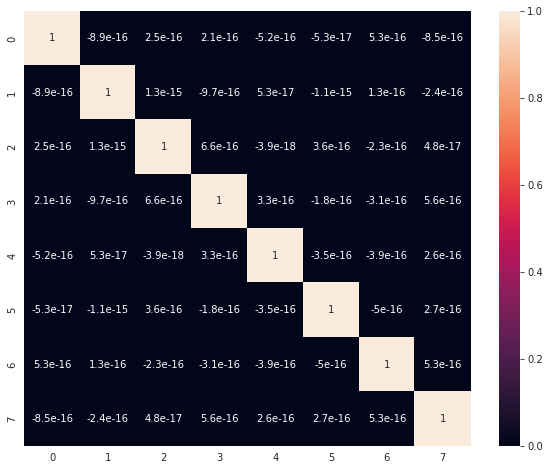

In [ ]:
# Heatmap pca
fig = plt.figure(figsize=(10, 8))
sns.heatmap(X_pca.corr(), annot=True)

##Data Splitting

In [ ]:
# Normal data
X_train, X_test, y_train, y_test = train_test_split(X_Scaled, y, test_size=0.2, shuffle=True, random_state=2)

# PCA transformed data
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_pca, y, test_size=0.2, shuffle=True, random_state=2)

##TPOT

In [ ]:
# Normal data
start = timeit.default_timer()

tpot = TPOTClassifier(
    verbosity=2, generations=5,
    n_jobs=-1, population_size=20,
    cv=5, config_dict='TPOT light')

tpot.fit(X_train, y_train)

stop = timeit.default_timer()

Optimization Progress:   0%|          | 0/120 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.8494199746238899

Generation 2 - Current best internal CV score: 0.8494199746238899

Generation 3 - Current best internal CV score: 0.8494199746238899

Generation 4 - Current best internal CV score: 0.8494199746238899

Generation 5 - Current best internal CV score: 0.8494199746238899

Best pipeline: KNeighborsClassifier(DecisionTreeClassifier(input_matrix, criterion=entropy, max_depth=4, min_samples_leaf=9, min_samples_split=9), n_neighbors=75, p=1, weights=distance)


In [ ]:
print(f'Elapsed time: {stop-start}s')

Elapsed time: 7339.241790124999s


In [ ]:
tpot.fitted_pipeline_

Pipeline(steps=[('stackingestimator',
                 StackingEstimator(estimator=DecisionTreeClassifier(criterion='entropy',
                                                                    max_depth=4,
                                                                    min_samples_leaf=9,
                                                                    min_samples_split=9))),
                ('kneighborsclassifier',
                 KNeighborsClassifier(n_neighbors=75, p=1,
                                      weights='distance'))])

In [ ]:
tpot.score(X_test, y_test)

0.8473501051257885

In [ ]:
y_pred = tpot.predict(X_test)

In [ ]:
# PCA transformed
start = timeit.default_timer()

tpot_pca = TPOTClassifier(
    verbosity=2, generations=5,
    n_jobs=-1, population_size=20,
    cv=5, config_dict='TPOT light')

tpot_pca.fit(X_train_pca, y_train_pca)

stop = timeit.default_timer()

Optimization Progress:   0%|          | 0/120 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.8371488127605582

Generation 2 - Current best internal CV score: 0.8374297625521117

Generation 3 - Current best internal CV score: 0.8376382091716513

Generation 4 - Current best internal CV score: 0.8388888888888889

Generation 5 - Current best internal CV score: 0.8388888888888889

Best pipeline: KNeighborsClassifier(LogisticRegression(input_matrix, C=10.0, dual=False, penalty=l2), n_neighbors=31, p=1, weights=uniform)


In [ ]:
print(f'Elapsed time: {stop-start}s')

Elapsed time: 5607.451560766s


In [ ]:
tpot_pca.fitted_pipeline_

Pipeline(steps=[('stackingestimator',
                 StackingEstimator(estimator=SGDClassifier(alpha=0.001,
                                                           eta0=1.0,
                                                           l1_ratio=0.25,
                                                           learning_rate='invscaling',
                                                           loss='squared_hinge',
                                                           penalty='elasticnet',
                                                           power_t=1.0))),
                ('xgbclassifier',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, enable_categorical=False,
                               gamma=...-1, importance_type=None,
                               interaction_constraints='', learning_rate=0.01,
                              

In [ ]:
tpot_pca.score(X_test_pca, y_test_pca)

0.8344812586094396

In [ ]:
y_pred_pca = tpot_pca.predict(X_test_pca)

#Evaluation

In [ ]:
# Normal data
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.97      0.91     21934
           1       0.75      0.38      0.51      5652

    accuracy                           0.85     27586
   macro avg       0.80      0.68      0.71     27586
weighted avg       0.84      0.85      0.83     27586



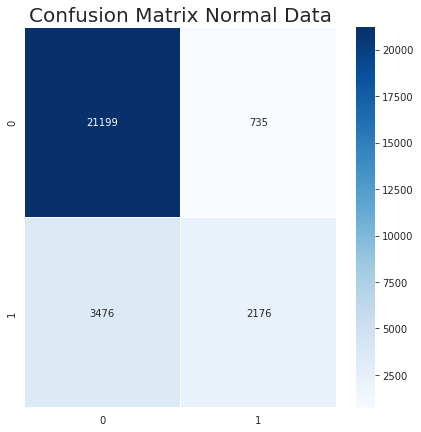

In [ ]:
# Confusion Matrix
plt.rcParams['figure.figsize'] = (7,7)
sns.heatmap(confusion_matrix(y_test, y_pred), annot = True, fmt='.0f', linewidths=0.5, cmap='Blues')
plt.title('Confusion Matrix Normal Data', fontsize=20)
plt.show()

In [ ]:
# PCA transformed data
print(classification_report(y_test_pca, y_pred_pca))

              precision    recall  f1-score   support

           0       0.86      0.95      0.90     21934
           1       0.68      0.38      0.49      5652

    accuracy                           0.84     27586
   macro avg       0.77      0.67      0.69     27586
weighted avg       0.82      0.84      0.82     27586



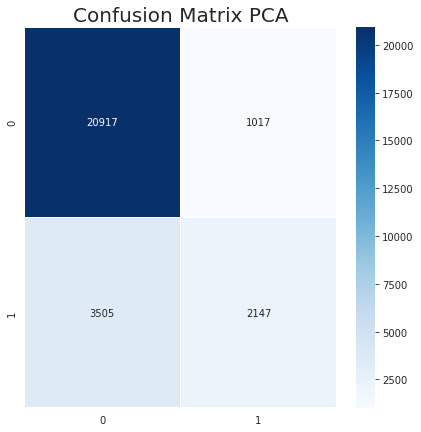

In [ ]:
# Confusion Matrix
plt.rcParams['figure.figsize'] = (7,7)
sns.heatmap(confusion_matrix(y_test_pca, y_pred_pca), annot = True, fmt='.0f', linewidths=0.5, cmap='Blues')
plt.title('Confusion Matrix PCA', fontsize=20)
plt.show()

##Time difference

In [ ]:
# Perbedaan waktu eksekusi tpot
print(7339.241790124999 - 5607.451560766, 's')

1731.7902293589996 s


# Data Hasil Eksplorasi

In [ ]:
from google.colab import drive
drive.mount('/drive')

Mounted at /drive


In [ ]:
df_clean.to_csv('/drive/My Drive/openme/dataDiolahAML.csv')

# Kesimpulan
1. Perbedaan akurasi tidak jauh. Untuk model tpot biasa sebesar 85%. Untuk model tpot pca sebesar 84%
2. Proses training dengan data PCA 1732 detik lebih cepat daripada dengan data normal
3. PCA menghilangkan masalah multicollinearity, tetapi tidak ada efek yang terlihat pada hasil akhir akurasi model

# Saran


*   Gunakan konfigurasi TPOT lainnya, seperti default atau MDR. Sangat disarankan untuk mencoba konfigurasi cuML.
*   Gunakan tools automl selain TPOT.
*   Lakukan augmentasi atau undersampling data.

